In [2]:
import tensorflow as tf
import numpy as np
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Model Define

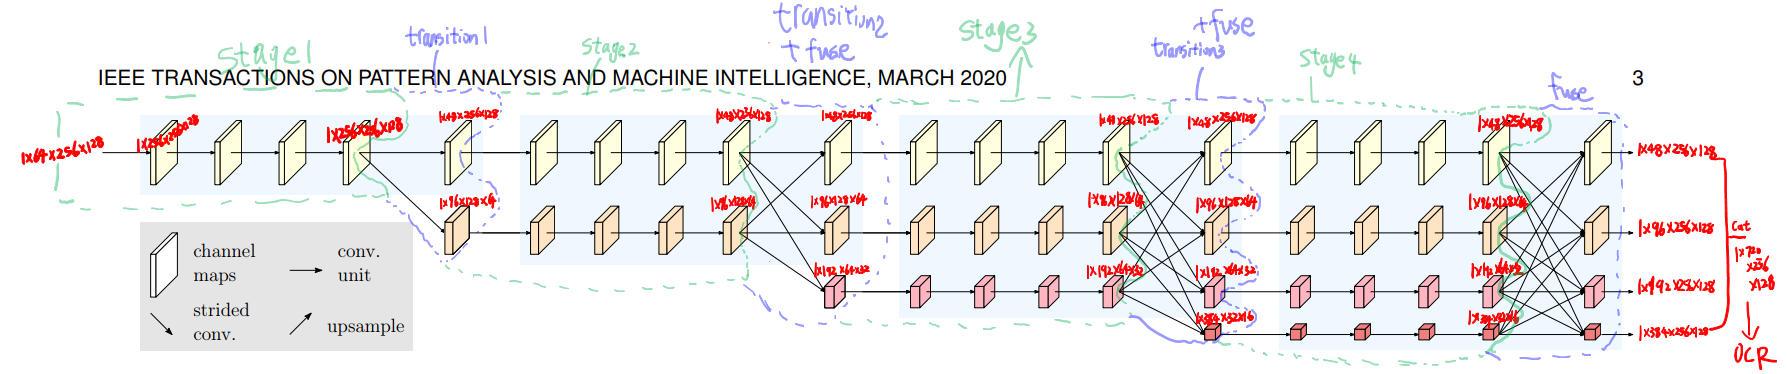

In [3]:
def hr_basic_block(x, n_feature, stride_size = (1, 1), shortcut = False, **kwargs):
    out = tf.keras.layers.Conv2D(n_feature, 3, strides = stride_size, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    out = tf.keras.layers.Conv2D(n_feature, 3, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
    
    if shortcut:
        x = tf.keras.layers.Conv2D(n_feature, 1, strides = stride_size, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x)
        x = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(x)
        out = tf.keras.layers.Add()([out, x])
    else:
        out = tf.keras.layers.Add()([out, x])
    
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    return out

In [4]:
def hr_bottleneck_block(x, n_feature, stride_size = (1, 1), shortcut = False, expansion = 4, **kwargs):
    n_decode_filter = n_feature // expansion
    out = tf.keras.layers.Conv2D(n_decode_filter, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    out = tf.keras.layers.Conv2D(n_decode_filter, 3, strides = stride_size, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    out = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
   
    if shortcut:
        x = tf.keras.layers.Conv2D(n_feature, 1, strides = stride_size, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x)
        x = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(x)
        out = tf.keras.layers.Add()([out, x])
    else:
        out = tf.keras.layers.Add()([out, x])
    
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    return out

In [5]:
def hr_transition_block(x, n_feature, **kwargs):
    if not isinstance(x, list):
        x = [x]
    if isinstance(n_feature, int):
        n_feature = [n_feature * (2 ** pow) for pow in range(len(x) + 1)]

    out = []
    for index, _n_feature in enumerate(n_feature):
        if (index + 1) == len(n_feature):
            feature = x[index - 1]
            stride_size = (2, 2)
        else:
            feature = x[index]
            stride_size = (1, 1)
        o = tf.keras.layers.Conv2D(_n_feature, 3, strides = stride_size, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(feature)
        o = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(o)
        o = tf.keras.layers.Activation(tf.keras.activations.relu)(o)
        out.append(o)
    return out

In [6]:
def hr_module(x, n_branch = 4, shortcut = False, **kwargs):
    if not isinstance(x, list):
        x = [x]
    n_feature = [tf.keras.backend.int_shape(_x)[-1] for _x in x]

    out = list(x)
    # branch
    for _ in range(n_branch):
        for index, _n_feature in enumerate(n_feature):
            out[index] = hr_basic_block(out[index], _n_feature, shortcut = shortcut, **kwargs)

    # fuse
    outs = []
    for index, _n_feature in enumerate(n_feature):
        _out = []
        for seq, o in enumerate(out):
            if seq < index:
                for k in range(index - seq):
                    o = tf.keras.layers.Conv2D(_n_feature, 3, strides = 2, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(o)
                    o = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(o)
                    if k != (index - seq - 1):
                        o = tf.keras.layers.Activation(tf.keras.activations.relu)(o)
            elif seq == index:
                pass
            else: #index < seq
                o = tf.keras.layers.Conv2D(_n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(o)
                o = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(o)
                upsample_size = [2 ** (seq - index)] * 2
                o = tf.keras.layers.UpSampling2D(upsample_size, interpolation = "bilinear")(o)
            _out.append(o)
        _out = tf.keras.layers.Add()(_out)
        _out = tf.keras.layers.Activation(tf.keras.activations.relu)(_out)
        outs.append(_out)
    return outs

In [7]:
def object_attention_context(feature, prob, scale = 1):
    feature = tf.keras.layers.Reshape([-1, tf.keras.backend.int_shape(feature)[-1]])(feature)
    feature = tf.keras.layers.Permute([2, 1])(feature)
    prob = tf.keras.layers.Reshape([-1, tf.keras.backend.int_shape(prob)[-1]])(prob)
    prob = tf.keras.activations.softmax(prob * scale, axis = -2)
    context = tf.keras.layers.Dot([2, 1])([feature, prob]) #batch x featrue ch x prob ch
    context = tf.keras.backend.expand_dims(context, axis = -2) #batch x featrue ch x 1 x prob ch
    return context

In [8]:
def object_attention(feature, prob, n_feature = 256, scale = 1, **kwargs):
    if 1 < scale:
        feature = tf.keras.layers.MaxPooling2D((scale, scale), padding = "same")(feature)
    proxy_context = object_attention_context(feature, prob, scale)

    query = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(feature)
    query = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(query)
    query = tf.keras.layers.Activation(tf.keras.activations.relu)(query)
    query = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(query)
    query = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(query)
    query = tf.keras.layers.Activation(tf.keras.activations.relu)(query)
    query = tf.keras.layers.Reshape([-1, tf.keras.backend.int_shape(query)[-1]])(query)

    key = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(proxy_context)
    key = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(key)
    key = tf.keras.layers.Activation(tf.keras.activations.relu)(key)
    key = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(key)
    key = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(key)
    key = tf.keras.layers.Activation(tf.keras.activations.relu)(key)
    key = tf.keras.layers.Reshape([-1, tf.keras.backend.int_shape(key)[-1]])(key)
    key = tf.keras.layers.Permute([2, 1])(key)

    value = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(proxy_context)
    value = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(value)
    value = tf.keras.layers.Activation(tf.keras.activations.relu)(value)
    value = tf.keras.layers.Reshape([-1, tf.keras.backend.int_shape(value)[-1]])(value)

    sim = tf.keras.layers.Dot([2, 1])([query, key])
    sim = sim * (n_feature ** -0.5)
    sim = tf.keras.activations.softmax(sim)

    context = tf.keras.layers.Dot([2, 1])([sim, value])
    context = tf.keras.layers.Reshape(tf.keras.backend.int_shape(feature)[-3:-1] + (n_feature,))(context)
    context = tf.keras.layers.Conv2D(tf.keras.backend.int_shape(feature)[-1], 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(context)
    context = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(context)
    context = tf.keras.layers.Activation(tf.keras.activations.relu)(context)
    
    if 1 < scale:
        context = tf.keras.layers.UpSampling2D((scale, scale))(context)
    return context

In [9]:
def ocr_module(feature, prob, n_feature = 512, n_attention_feature = 256, dropout_rate = 0.05, scale = 1, **kwargs):
    context = object_attention(feature, prob, n_attention_feature, scale, **kwargs)
    out = tf.keras.layers.Concatenate(axis = -1)([feature, context])
    out = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    out = tf.keras.layers.Dropout(dropout_rate)(out)
    return out

In [10]:
def hrnet_v2(x, n_class = 19, include_top = True, n_channel = 48, n_module = [1, 4, 3], n_branch = [2, 3, 4], stage1_channel = 64, stage1_module = 1, ocr_feature_channel = 512, ocr_attention_channel = 256, ocr_dropout_rate = 0.05, ocr_scale = 1, mode = "ocr", **kwargs):
    if mode not in ("seg", "clsf", "ocr"):
        raise ValueError("unknown mode '{0}'".format(mode))
    if isinstance(n_channel, int):
        n_channel = [n_channel * (2 ** pow) for pow in range(4)]
    if isinstance(n_module, int):
        n_module = [n_module] * 3
    if isinstance(n_branch, int):
        n_branch = [n_branch] * 3

    if not isinstance(x, list):
        #Stem
        out = tf.keras.layers.Conv2D(64, 3, strides = 2, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x)
        out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
        out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
        out = tf.keras.layers.Conv2D(64, 3, strides = 2, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
        out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
        out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
        
        #Stage1
        out = hr_bottleneck_block(out, stage1_channel, shortcut = True, **kwargs)
        for _ in range(1, stage1_module):
            out = hr_bottleneck_block(out, stage1_channel, **kwargs)
    else:
        x = list(x)
        shape = tf.keras.backend.int_shape(x[0])[-3:-1]
        for index in range(len(x)):
            o = tf.keras.layers.Conv2D(n_channel[index], 3, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x[index])
            o = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(o)
            o = tf.keras.layers.Activation(tf.keras.activations.relu)(o)
            if 0 < index:
                target_size = np.divide(shape, 2 ** index).astype(np.int32)
                o = tf.image.resize(o, target_size, method = "bilinear")
            x[index] = o

    #Stage2: transition -> branch -> fuse x2
    # transition
    if not isinstance(x, list):
        out = hr_transition_block(out, n_channel[:2], **kwargs)
    else:
        out = x[:2]
    # branch & fuse
    for _ in range(n_module[0]):
        out = hr_module(out, n_branch = n_branch[0], shortcut = False, **kwargs)

    #Stage3: transition -> branch -> fuse x3
    # transition
    if not isinstance(x, list):
        out = hr_transition_block(out, n_channel[:3], **kwargs)
    else:
        out = out + x[2:3]
    # branch & fuse
    for _ in range(n_module[1]):
        out = hr_module(out, n_branch = n_branch[1], shortcut = False, **kwargs)

    #Stage4: transition -> branch -> fuse x4
    # transition
    if not isinstance(x, list):
        out = hr_transition_block(out, n_channel[:4], **kwargs)
    else:
        out = out + x[3:4]
    # branch & fuse
    for _ in range(n_module[2]):
        out = hr_module(out, n_branch = n_branch[2], shortcut = False, **kwargs)

    if mode != "clsf":
        #Concatenate
        for index in range(1, len(out)):
            upsample_size = np.divide(tf.keras.backend.int_shape(out[0])[-3:-1], tf.keras.backend.int_shape(out[index])[-3:-1]).astype(np.int32)
            out[index] = tf.keras.layers.UpSampling2D(upsample_size, interpolation = "bilinear")(out[index])
        out = tf.keras.layers.Concatenate(axis = -1)(out)
    else:
        #Add
        o = hr_bottleneck_block(out[0], tf.keras.backend.int_shape(out[0])[-1], **kwargs)
        for _o in out[1:]:
            ch = tf.keras.backend.int_shape(_o)[-1]
            _o = hr_bottleneck_block(_o, ch, **kwargs)
            o = tf.keras.layers.Conv2D(ch, 3, strides = 2, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(o)
            o = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(o)
            o = tf.keras.layers.Activation(tf.keras.activations.relu)(o)
            o = tf.keras.layers.Add()([o, _o])
        out = o

    if include_top:
        if mode != "clsf":
            out_aux = tf.keras.layers.Conv2D(tf.keras.backend.int_shape(out)[-1], 1, use_bias = True, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
            out_aux = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out_aux)
            out_aux = tf.keras.layers.Activation(tf.keras.activations.relu)(out_aux)
            out_aux = tf.keras.layers.Conv2D(n_class, 1, use_bias = True, kernel_initializer = "he_normal", name = "logits", **kwargs)(out_aux)
            if mode == "ocr":
                out = tf.keras.layers.Conv2D(ocr_feature_channel, 3, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
                out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
                out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
                out = ocr_module(out, out_aux, ocr_feature_channel, ocr_attention_channel, ocr_dropout_rate, ocr_scale, **kwargs)
                out = tf.keras.layers.Conv2D(n_class, 1, use_bias = True, kernel_initializer = "he_normal", name = "logits_ocr", **kwargs)(out)
            else:
                out = out_aux
        else:
            out = tf.keras.layers.Conv2D(2048, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
            out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
            out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
            out = tf.keras.layers.GlobalAveragePooling2D()(out)
            out = tf.keras.layers.Dense(n_class, use_bias = True, name = "logits")(out)
    return out

In [11]:
def hrnet18_v2(x, n_class = 19, include_top = True, mode = "ocr"):
    out = hrnet_v2(x, n_class, include_top, n_channel = [18, 36, 72, 144], n_module = [1, 4, 3], n_branch = [2, 3, 4], stage1_channel = 64, stage1_module = 1, ocr_feature_channel = 512, ocr_attention_channel = 256, ocr_dropout_rate = 0.05, ocr_scale = 1, mode = mode)
    return out

def hrnet32_v2(x, n_class = 19, include_top = True, mode = "ocr"):
    out = hrnet_v2(x, n_class, include_top, n_channel = [32, 64, 128, 256], n_module = [1, 4, 3], n_branch = [2, 3, 4], stage1_channel = 64, stage1_module = 1, ocr_feature_channel = 512, ocr_attention_channel = 256, ocr_dropout_rate = 0.05, ocr_scale = 1, mode = mode)
    return out

def hrnet48_v2(x, n_class = 19, include_top = True, mode = "ocr"):
    out = hrnet_v2(x, n_class, include_top, n_channel = [48, 94, 192, 384], n_module = [1, 4, 3], n_branch = [2, 3, 4], stage1_channel = 64, stage1_module = 1, ocr_feature_channel = 512, ocr_attention_channel = 256, ocr_dropout_rate = 0.05, ocr_scale = 1, mode = mode)
    return out

# Model Compile With seg Mode

mode = seg > hrnet v2 + semantic segmentation, clsf > hrnet v2 + classifier, ocr > hrnet v2 + ocr + semantic segmentation

In [12]:
x = tf.keras.layers.Input(shape = (256, 512, 3))
out = hrnet48_v2(x, n_class = 19, include_top = True, mode = "ocr") 
out = tf.keras.layers.UpSampling2D((4, 4))(out)
model = tf.keras.Model(x, out)

# loss = tf.keras.losses.sparse_categorical_crossentropy
# opt = tf.keras.optimizers.SGD(1e-3, momentum = 0.9, nesterov = True)
# metric = [tf.keras.metrics.sparse_categorical_accuracy]
# model.compile(loss = loss, optimizer = opt, metrics = metric)

In [13]:
# #hrnet v2 with backbone (custom development)
# x = tf.keras.layers.Input(shape = (224, 224, 3))
# model = tf.keras.applications.MobileNetV2(input_tensor = x, include_top = False)
# layers = ["block_3_expand_relu", "block_6_expand_relu", "block_13_expand_relu", "out_relu"]
# layers = [model.get_layer(l).output for l in layers]
# out = hrnet18_v2(layers, n_class = 2, include_top = True, mode = "ocr")
# out = tf.keras.layers.UpSampling2D((4, 4))(out)
# model = tf.keras.Model(x, out)

# #manual initailize (hrnet18_v2 + ocr)
# x = tf.keras.layers.Input(shape = (224, 224, 3))
# out = hrnet_v2(x, n_class = 2, include_top = True, n_channel = [18, 36, 72, 144], n_module = [1, 4, 3], n_branch = [2, 3, 4], stage1_channel = 64, stage1_module = 1, ocr_feature_channel = 512, ocr_attention_channel = 256, ocr_dropout_rate = 0.05, ocr_scale = 1, mode = "ocr")
# out = tf.keras.layers.UpSampling2D((4, 4))(out)
# model = tf.keras.Model(x, out)

# Model Compile With MobileNet

In [14]:
# x = tf.keras.layers.Input(shape = (256, 256, 3))
# model = tf.keras.applications.MobileNetV2(input_tensor = x, include_top = False)
# layers = ["block_3_expand_relu", "block_6_expand_relu", "block_13_expand_relu", "out_relu"]
# layers = [model.get_layer(l).output for l in layers]
# out = hrnet48_v2(layers, n_class = 19, include_top = True, mode = "ocr")
# out = tf.keras.layers.UpSampling2D((4, 4))(out)
# model = tf.keras.Model(x, out)

# loss = tf.keras.losses.sparse_categorical_crossentropy
# opt = tf.keras.optimizers.SGD(1e-3, momentum = 0.9, nesterov = True)
# metric = [tf.keras.metrics.sparse_categorical_accuracy]

# # miou_metric = tf.keras.metrics.MeanIoU(num_classes=19)

# model.compile(loss = loss, optimizer = opt, metrics = metric)

# Data Processing

In [15]:
img = glob.glob('./images/train/*/*.png')
label = [path.replace('images', 'gtFine').replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png') for path in img]

index = np.random.permutation(len(img))
img = np.array(img)[index]
label = np.array(label)[index]

img_val = glob.glob('./images/val/*/*.png')
label_val = [path.replace('images', 'gtFine').replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png') for path in img_val]

train_count = len(label)
val_count = len(label_val)

dataset_train = tf.data.Dataset.from_tensor_slices((img, label))
dataset_val = tf.data.Dataset.from_tensor_slices((img_val, label_val))

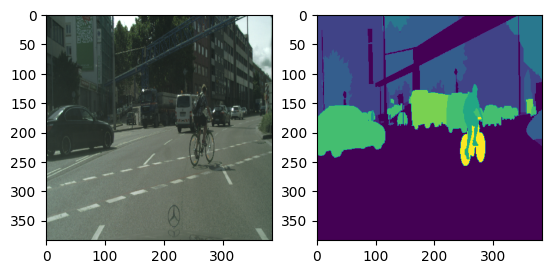

In [16]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img

def read_png_label(path):
    with tf.device('/cpu:0'): 
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.where(img == 255, tf.zeros_like(img), img)
    return img

def crop_img(img, mask):

    # 确保img也是float32类型
    img_uint8 = tf.cast(img, tf.uint8)

    concat_img = tf.concat([img_uint8, mask], axis=-1)
    concat_img = tf.image.resize(concat_img, (400, 400), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img, [384, 384, tf.shape(concat_img)[-1]])

    # 将裁剪后的图像和掩码分离，并将掩码转换回原始数据类型
    return crop_img[:, :, :3], tf.cast(crop_img[:, :, 3:], mask.dtype)



img_1 = read_png(img[0])
label_1 = read_png_label(label[0])
concat_img = tf.concat([img_1, label_1], axis=-1)
img_1, label_1 = crop_img(img_1, label_1)

plt.subplot(1,2,1)
plt.imshow(img_1.numpy())
plt.subplot(1,2,2)
plt.imshow(np.squeeze(label_1.numpy()))

Data Augumentation

In [17]:
def normal(img, mask):
    img = tf.cast(img, tf.float32)/127.5 -1
    mask = tf.cast(mask, tf.int32)
    return img, mask

def load_image_train(img_path, mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)

    # 随机缩放
    scale = tf.random.uniform([], 0.7, 2)
    new_height = tf.cast(tf.cast(tf.shape(img)[0], tf.float32) * scale, tf.int32)
    new_width = tf.cast(tf.cast(tf.shape(img)[1], tf.float32) * scale, tf.int32)
    img = tf.image.resize(img, [new_height, new_width])
    mask = tf.image.resize(mask, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    img, mask = crop_img(img, mask)
    
    # 随机水平翻转
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)


    img, mask = normal(img, mask)

    return img, mask


def load_image_val(img_path, mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    img = tf.image.resize(img, (384, 384))
    mask = tf.image.resize(mask, (384, 384))
        
    img, mask = normal(img, mask)
    
    return img, mask

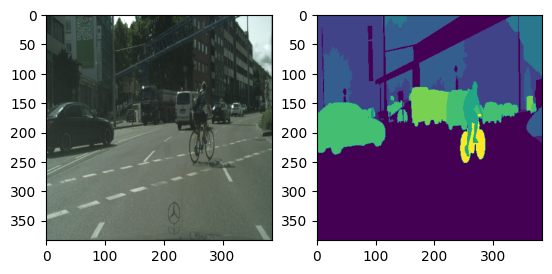

In [18]:
BCTCH_SIZE = 24
BUFFER_SIZE = 300
step_per_epoch = train_count//BCTCH_SIZE
val_step = val_count//BCTCH_SIZE

auto = tf.data.experimental.AUTOTUNE
dataset_train = dataset_train.map(load_image_train, num_parallel_calls=auto)
dataset_val = dataset_val.map(load_image_val, num_parallel_calls=auto)

for i, m in dataset_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((i.numpy() + 1)/2)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(m.numpy()))

dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BCTCH_SIZE)
dataset_val = dataset_val.batch(BCTCH_SIZE)

In [19]:
dataset_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384, 1), dtype=tf.int32, name=None))>

In [19]:
# model.fit(tr_data, validation_data = te_data, epochs = 50)

# Model Training

In [20]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)
    
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_iou = MeanIoU(19, name='train_iou')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_iou = MeanIoU(19, name='test_iou')

In [21]:
base_learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005
power = 0.9
total_steps = 121520

# 使用内置的多项式衰减学习率调度
learning_rate_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=total_steps,
    end_learning_rate=0.0,  # 结束时的学习率
    power=power
)

class SGDW(tf.keras.optimizers.SGD):
    def __init__(self, weight_decay, *args, **kwargs):
        super(SGDW, self).__init__(*args, **kwargs)
        self.weight_decay = weight_decay

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)  # handle learning rate decay
        wd = lr_t * self.weight_decay

        var.assign_sub((lr_t * grad) + (wd * var))

optimizer = SGDW(
    weight_decay=weight_decay,
    learning_rate=learning_rate_schedule,
    momentum=momentum
)

In [22]:
def weight_decay_loss(model, weight_decay):
    # 计算所有可训练参数的L2损失
    l2_losses = [tf.nn.l2_loss(t) for t in model.trainable_variables if 'bias' not in t.name]
    # 将所有L2损失相加，并乘以权重衰减系数
    return weight_decay * tf.add_n(l2_losses)

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        # 添加权重衰减损失
        loss += weight_decay_loss(model, weight_decay)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    train_iou(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_iou(labels, predictions)

EPOCHS = 490

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_iou.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_iou.reset_states()

    for images, labels in dataset_train:
        train_step(images, labels)

    for test_images, test_labels in dataset_val:
        test_step(test_images, test_labels)

    template = 'Epoch {:3d}, Loss: {:.3f}, Accuracy: {:.3f}, \
                IOU: {:.3f}, Test Loss: {:.3f}, \
                Test Accuracy: {:.3f}, Test IOU: {:.3f}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           train_iou.result(),
                           test_loss.result(),
                           test_accuracy.result()*100,
                           test_iou.result() 
                           ))

2024-01-23 05:14:50.709338: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-23 05:14:57.918612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-23 05:14:58.696364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-23 05:15:01.768071: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4c1aecdaa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-23 05:15:01.768139: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-01-23 05:15:01.843730: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cl

Epoch   1, Loss: 34.606, Accuracy: 62.071,                 IOU: 0.105, Test Loss: 1.010,                 Test Accuracy: 70.553, Test IOU: 0.137
Epoch   2, Loss: 33.373, Accuracy: 72.258,                 IOU: 0.168, Test Loss: 0.865,                 Test Accuracy: 75.101, Test IOU: 0.179
Epoch   3, Loss: 32.391, Accuracy: 75.203,                 IOU: 0.199, Test Loss: 0.824,                 Test Accuracy: 76.701, Test IOU: 0.204
Epoch   4, Loss: 31.468, Accuracy: 77.399,                 IOU: 0.216, Test Loss: 0.828,                 Test Accuracy: 76.337, Test IOU: 0.195
Epoch   5, Loss: 30.609, Accuracy: 78.383,                 IOU: 0.231, Test Loss: 0.777,                 Test Accuracy: 77.850, Test IOU: 0.213
Epoch   6, Loss: 29.781, Accuracy: 79.332,                 IOU: 0.241, Test Loss: 0.734,                 Test Accuracy: 78.744, Test IOU: 0.216
Epoch   7, Loss: 28.970, Accuracy: 80.319,                 IOU: 0.255, Test Loss: 0.826,                 Test Accuracy: 75.576, Test IOU

In [23]:
model.save('my_model.h5') 

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
model.save('my_model_file') 

INFO:tensorflow:Assets written to: my_model_file/assets


INFO:tensorflow:Assets written to: my_model_file/assets


In [22]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall

miou_metric = MeanIoU(num_classes=19)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()

model_path = 'last_epoch.h5'
model_1 = tf.keras.models.load_model(model_path)

num = 3
for image, mask in dataset_val.take(10):
    pred_mask = model_1.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    miou_metric.update_state(mask, pred_mask)
    accuracy_metric.update_state(mask, pred_mask)
    precision_metric.update_state(mask, pred_mask)
    recall_metric.update_state(mask, pred_mask)

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

miou = miou_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()

print("Mean IoU: ", miou)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x00000189D06AFCD0>.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27676\4247269979.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', num_classes)


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27676\4247269979.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27676\4247269979.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


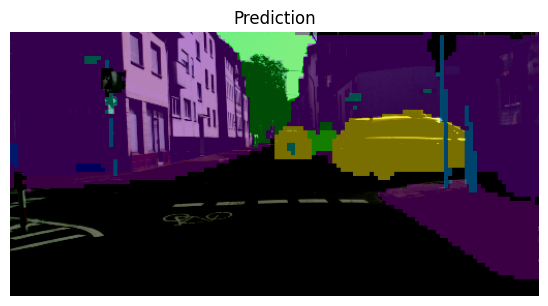

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


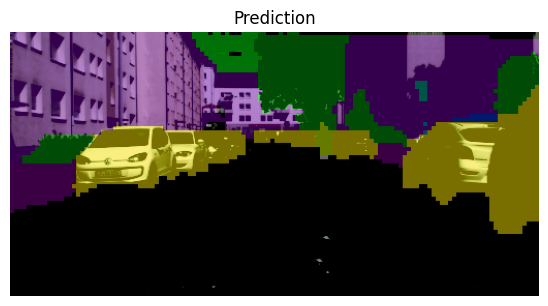

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


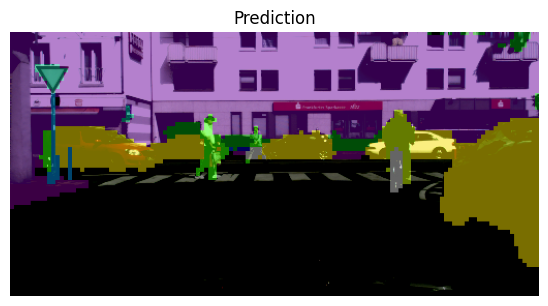

In [30]:
def plot_predictions(model, dataset, num_classes=19, num_samples=3):
    colors = plt.cm.get_cmap('nipy_spectral', num_classes)
    
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        predictions = tf.argmax(predictions, axis=-1)

        for i in range(num_samples):
            image = images[i].numpy()
            label = labels[i].numpy().squeeze()  # 假设标签是单通道的
            prediction = predictions[i].numpy()

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 2, 1)
            plt.title("Image")
            plt.imshow(image)
            plt.axis('off')

            # plt.subplot(1, 3, 2)
            # plt.title("True Label")
            # true_label_mask = colors(label)
            # plt.imshow(image)
            # plt.imshow(true_label_mask, cmap='nipy_spectral', vmin=0, vmax=num_classes-1, alpha=0.5)
            # plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Prediction")
            prediction_mask = colors(prediction)
            plt.imshow(image)
            plt.imshow(prediction_mask, cmap='nipy_spectral', vmin=0, vmax=num_classes-1, alpha=0.5)
            plt.axis('off')

            plt.show()

plot_predictions(model_1, dataset_val, num_classes=19, num_samples=3)

1/1 [==============================] - 0s 96ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


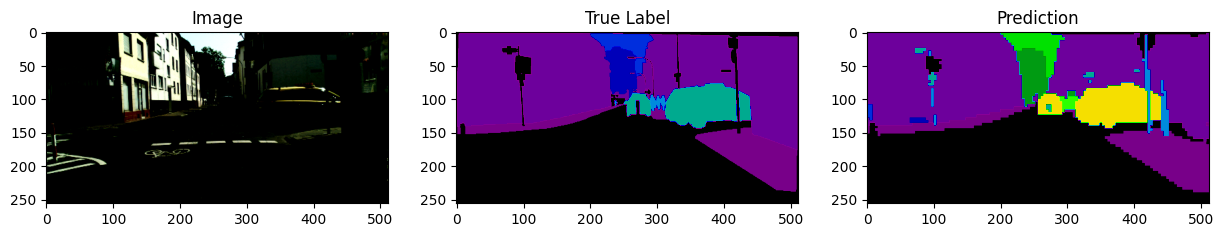

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


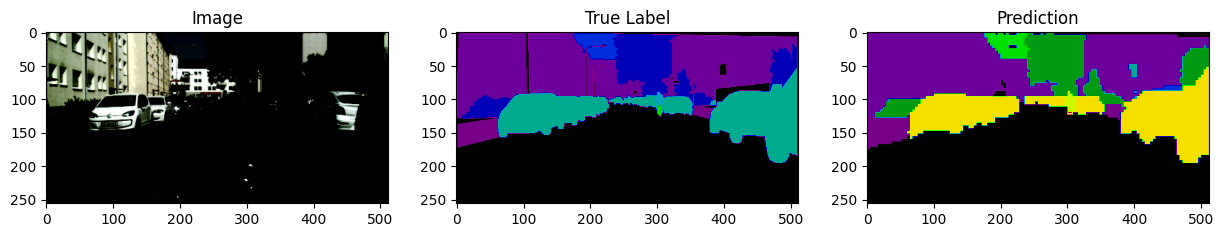

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


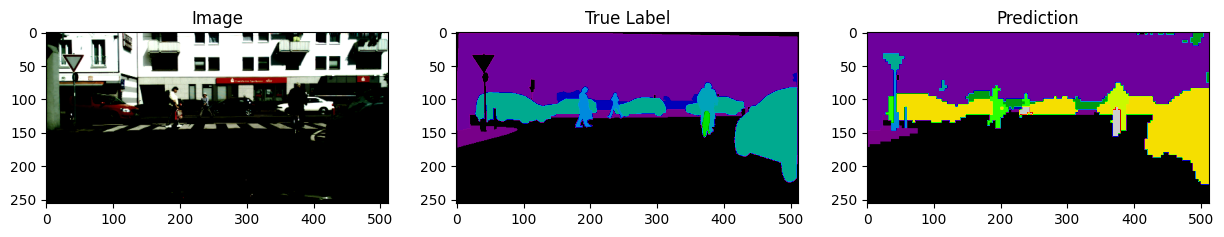

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


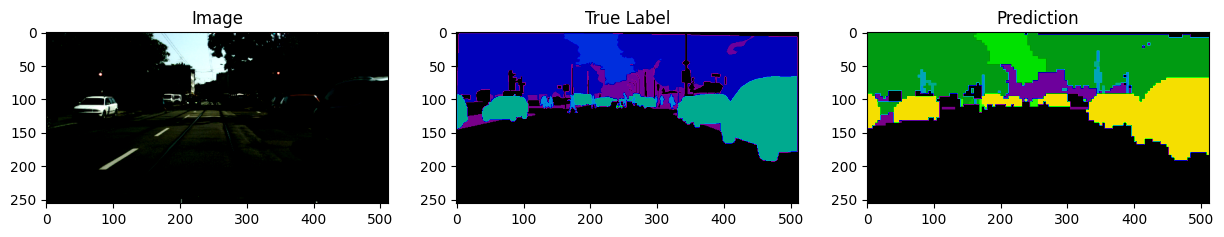

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


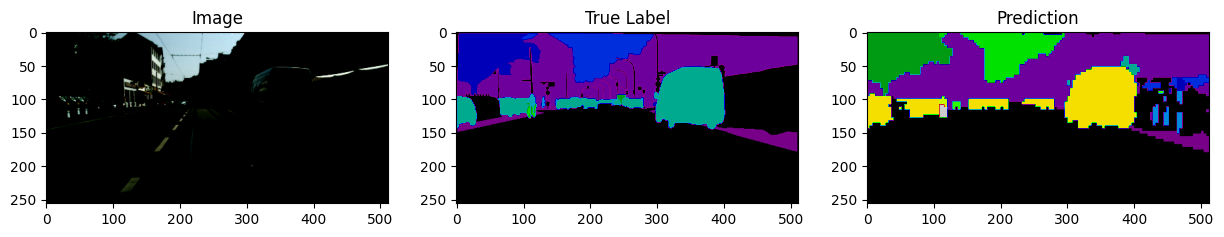

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


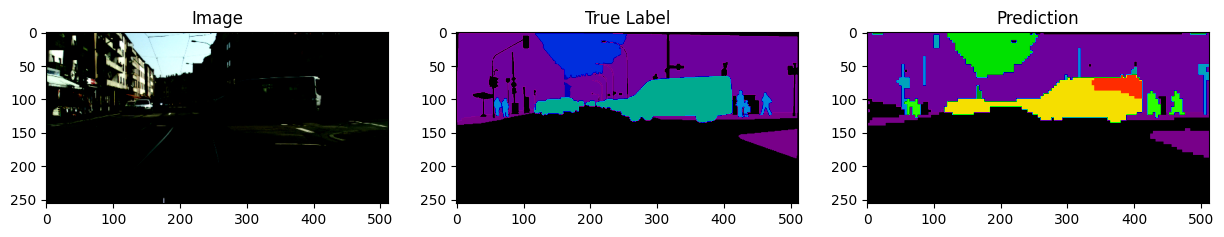

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


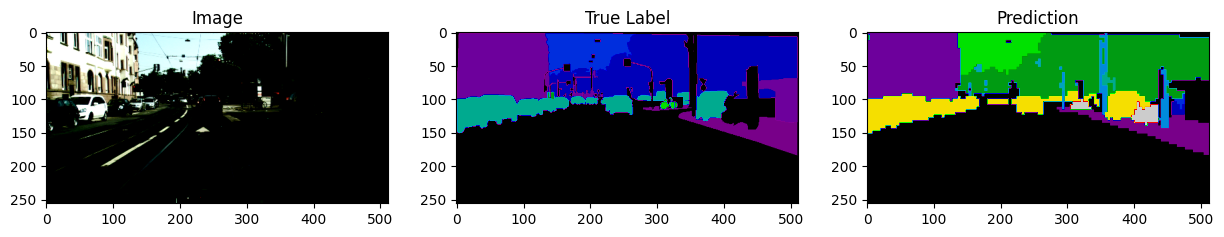

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


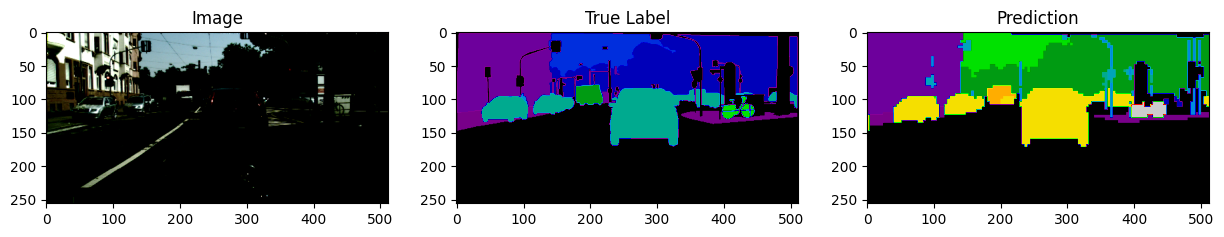

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


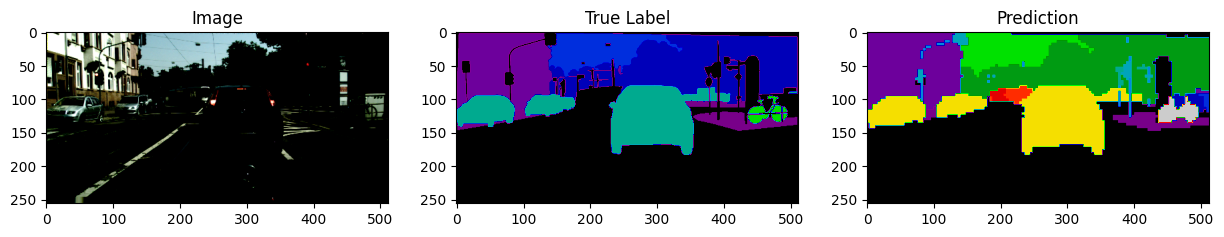

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


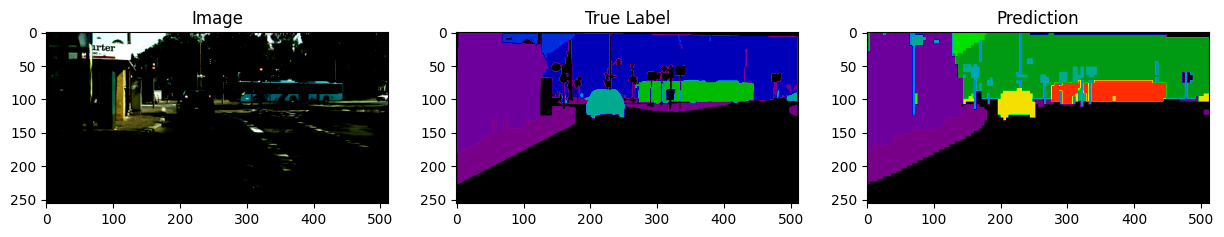

In [32]:
def plot_predictions(model, dataset, num_classes=19, num_samples=3):
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        predictions = tf.argmax(predictions, axis=-1)

        for i in range(num_samples):
            image = images[i].numpy()
            label = labels[i].numpy().squeeze()  # 假设标签是单通道的
            prediction = predictions[i].numpy()

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.title("Image")
            plt.imshow(image)

            plt.subplot(1, 3, 2)
            plt.title("True Label")
            plt.imshow(label, cmap='nipy_spectral', vmin=0, vmax=num_classes-1)

            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(prediction, cmap='nipy_spectral', vmin=0, vmax=num_classes-1)

            plt.show()

plot_predictions(model_1, dataset_val, num_classes=19, num_samples=10)